In [1]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
sys.path

['',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages/setuptools-15.2-py2.7.egg',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages/setuptools-15.2-py2.7.egg',
 '/home/jbourbeau/.local/lib/python2.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/i3ports/root-v5.34.18/lib',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/i3ports/lib/python2.7/site-packages',
 '/data/user/jbourbeau/metaprojects/icerec/V05-00-00/build/lib',
 '/home/jbourbeau/cr-composition/analysis',
 '/home/jbourbeau',
 '/home/jbourbeau/useful',
 '/home/jbourbeau/anisotropy',
 '/home/jbourbeau/ShowerLLH_scripts',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python27.zip',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/pyth

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

import composition as comp

%matplotlib inline

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
sns.set_palette('muted')
sns.set_color_codes()

In [4]:
df = comp.load_sim()
print('# events = {}'.format(len(df)))

/home/jbourbeau/cr-composition/composition/load_sim.py:105: RuntimeWarning: divide by zero encountered in log10
  df['log_NChannels_1_30'] = np.nan_to_num(np.log10(df['NChannels_1_30']))


Cut event flow:
              lap_reco_success:  0.612  0.612
                    lap_zenith:  0.713  0.577
                 num_hits_1_30:  0.624  0.562
                     IT_signal:  0.228  0.218
                StationDensity:  0.785  0.218
                max_qfrac_1_30:  0.772  0.218
               lap_containment:  0.617   0.17
              energy_range_lap:  0.413  0.116


# events = 89659


In [6]:
feature_list, feature_labels = comp.get_training_features()
print('training features = {}'.format(feature_list))
num_features = len(feature_list)
X_train, X_test, y_train, y_test, le = comp.get_train_test_sets(df, feature_list)

training features = ['lap_log_energy', 'InIce_log_charge_1_30', 'lap_cos_zenith', 'NChannels_1_30', 'log_s125', 'lap_likelihood']


In [6]:
pipeline = comp.get_pipeline('RF')
pipeline.fit(X_train, y_train)
scaler = pipeline.named_steps['scaler']
clf = pipeline.named_steps['classifier']
clf_name = clf.__class__.__name__

In [7]:
test_predictions = pipeline.predict(X_test)
test_acc = accuracy_score(y_test, test_predictions)
print('Test accuracy: {:.4%}'.format(test_acc))
train_predictions = pipeline.predict(X_train)
train_acc = accuracy_score(y_train, train_predictions)
print('Train accuracy: {:.4%}'.format(train_acc))

Test accuracy: 79.3128%
Train accuracy: 83.2858%


1) 0.381360127017
2) 0.265909889116
3) 0.14942532069
4) 0.115531686641
5) 0.0877729765361


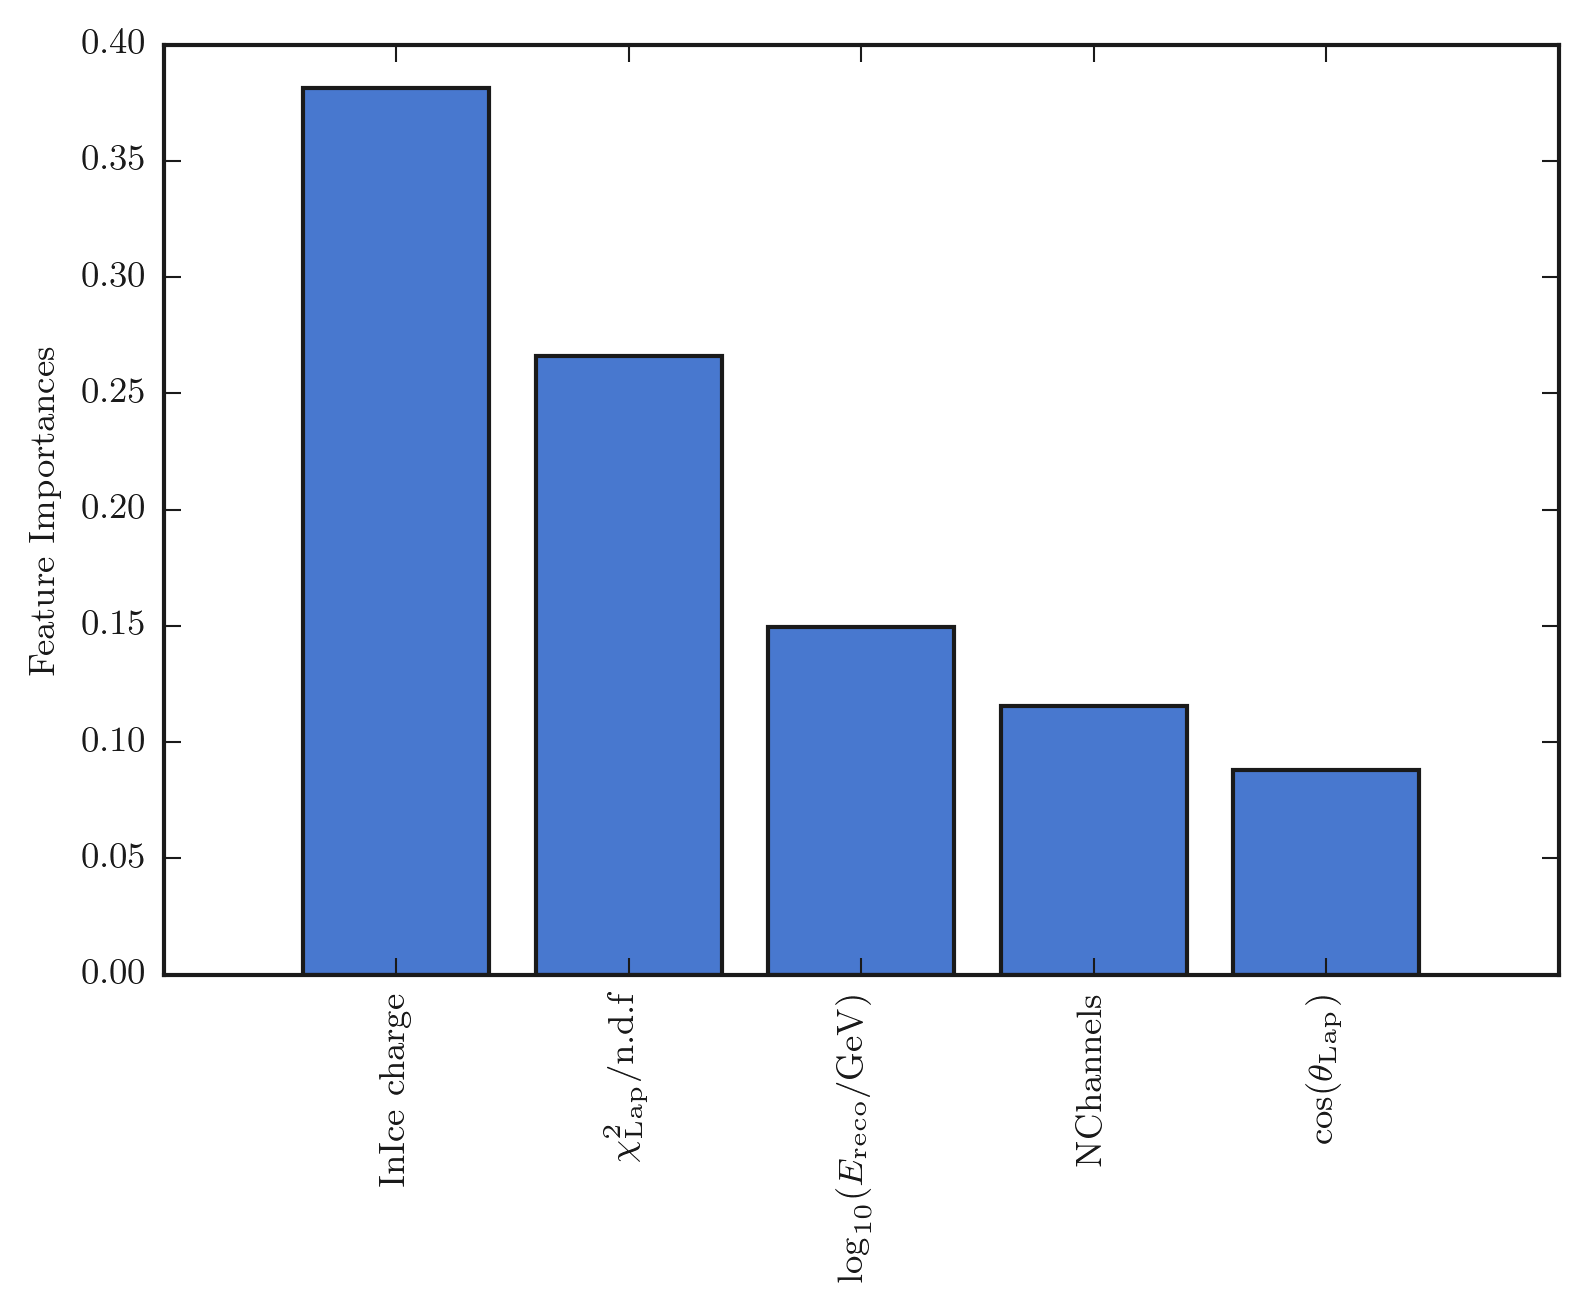

In [8]:
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots()
# feature_labels = np.array(['$\\log_{10}({\mathrm{E/GeV})$', 'InIce charge',
#                            '$\cos(\\theta)$', '$\mathrm{Laputop}\ \chi^2/\mathrm{n.d.f.}$', 'NChannels'])
for f in range(num_features):
    print('{}) {}'.format(f + 1, importances[indices[f]]))

plt.ylabel('Feature Importances')
plt.bar(range(num_features),
        importances[indices],
        align='center')

plt.xticks(range(num_features),
           feature_labels[indices], rotation=90)
plt.xlim([-1, len(feature_list)])
plt.show()

/home/jbourbeau/.local/lib/python2.7/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/home/jbourbeau/.local/lib/python2.7/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


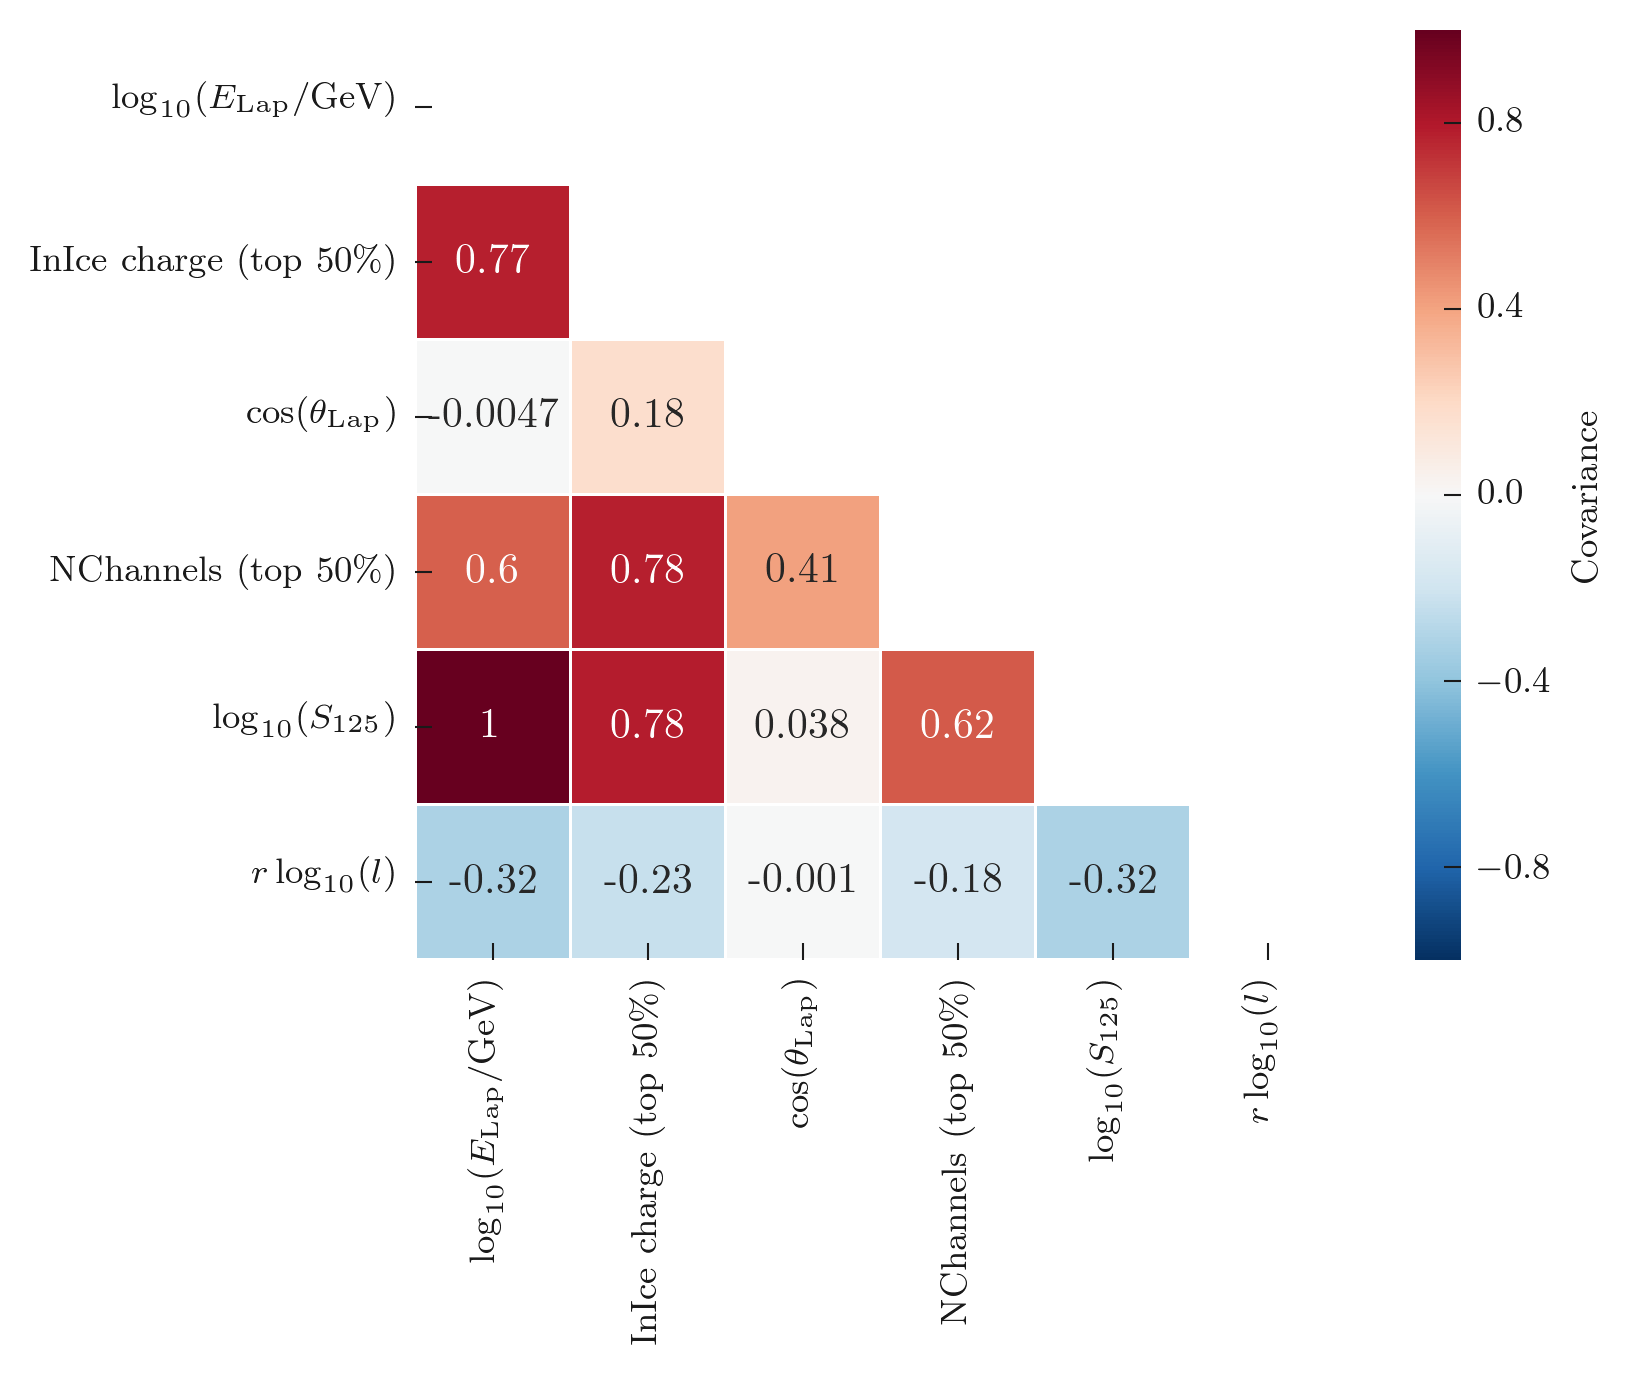

In [7]:
d = pd.DataFrame(df, columns=feature_list)
# Compute the correlation matrix
corr = d.corr().values
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots()
sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0,
            square=True, xticklabels=feature_labels, yticklabels=feature_labels,
            linewidths=.5, cbar_kws={'label': 'Covariance'}, annot=True, ax=ax)
plt.show()

In [15]:
corr = d.corr()

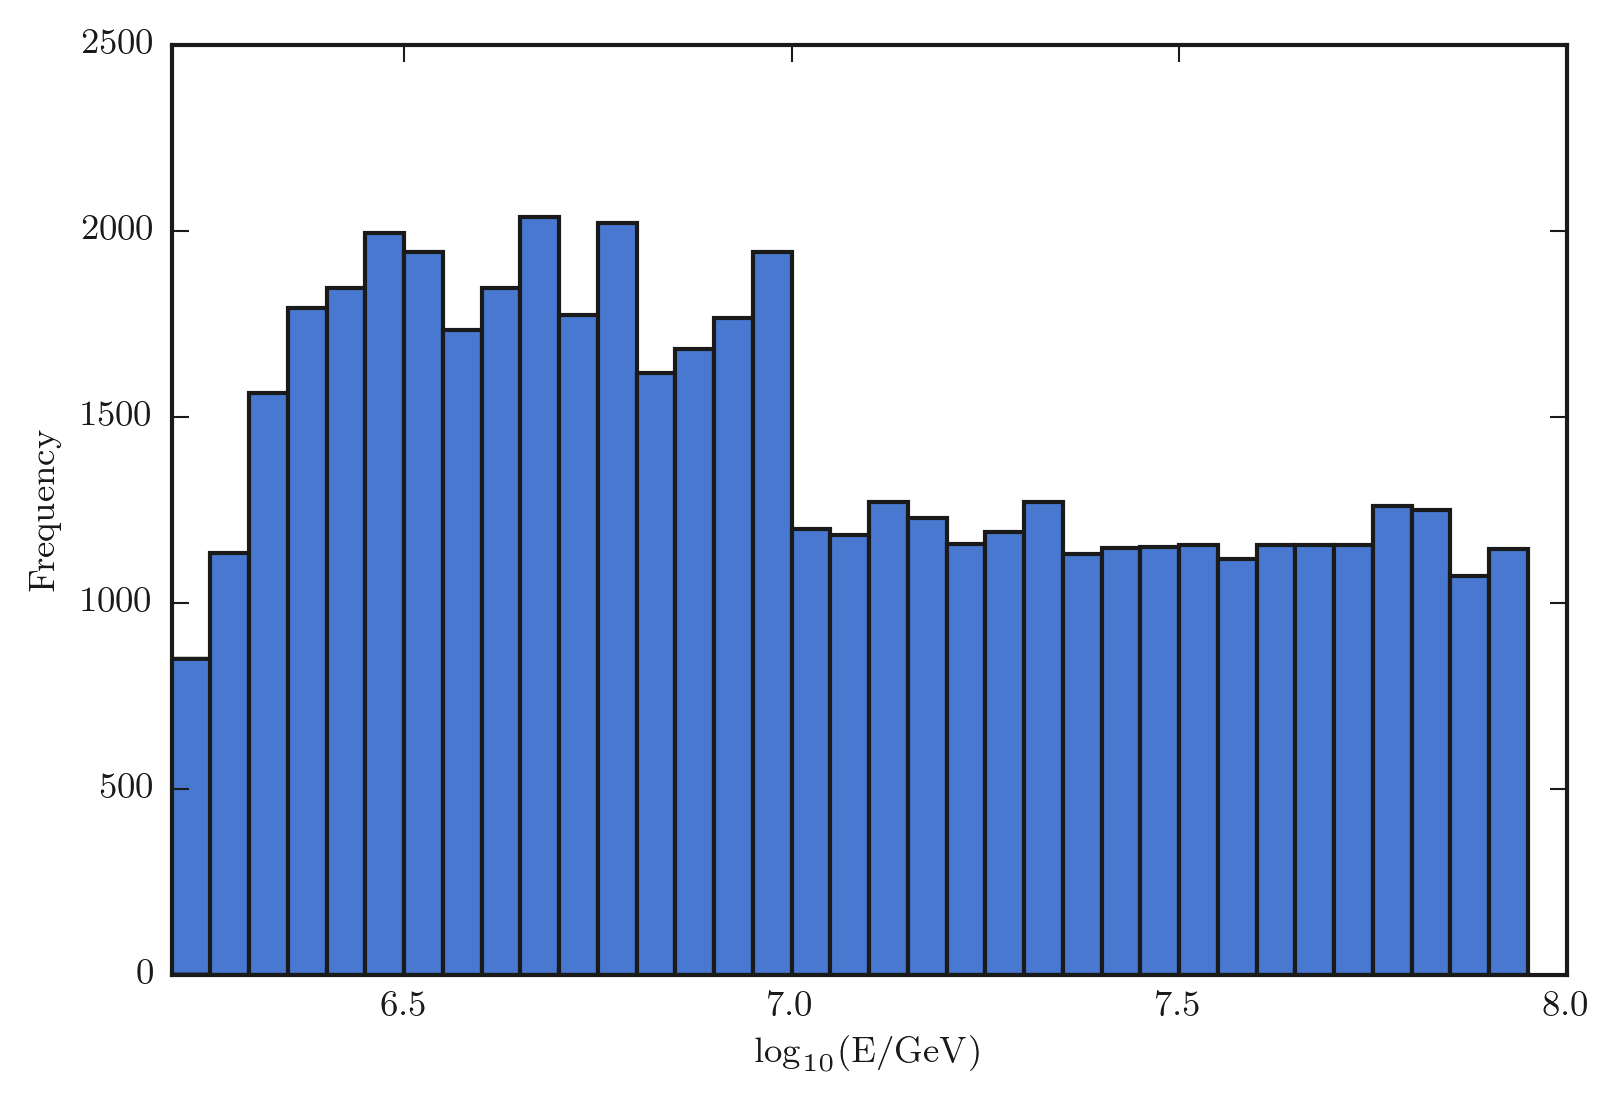

In [16]:
df.MC_log_energy.plot(kind='hist', xlim=[6.2, 8], bins=np.arange(6.2, 8, 0.05))
plt.xlabel('$\\log_{10}({\mathrm{E/GeV})$')

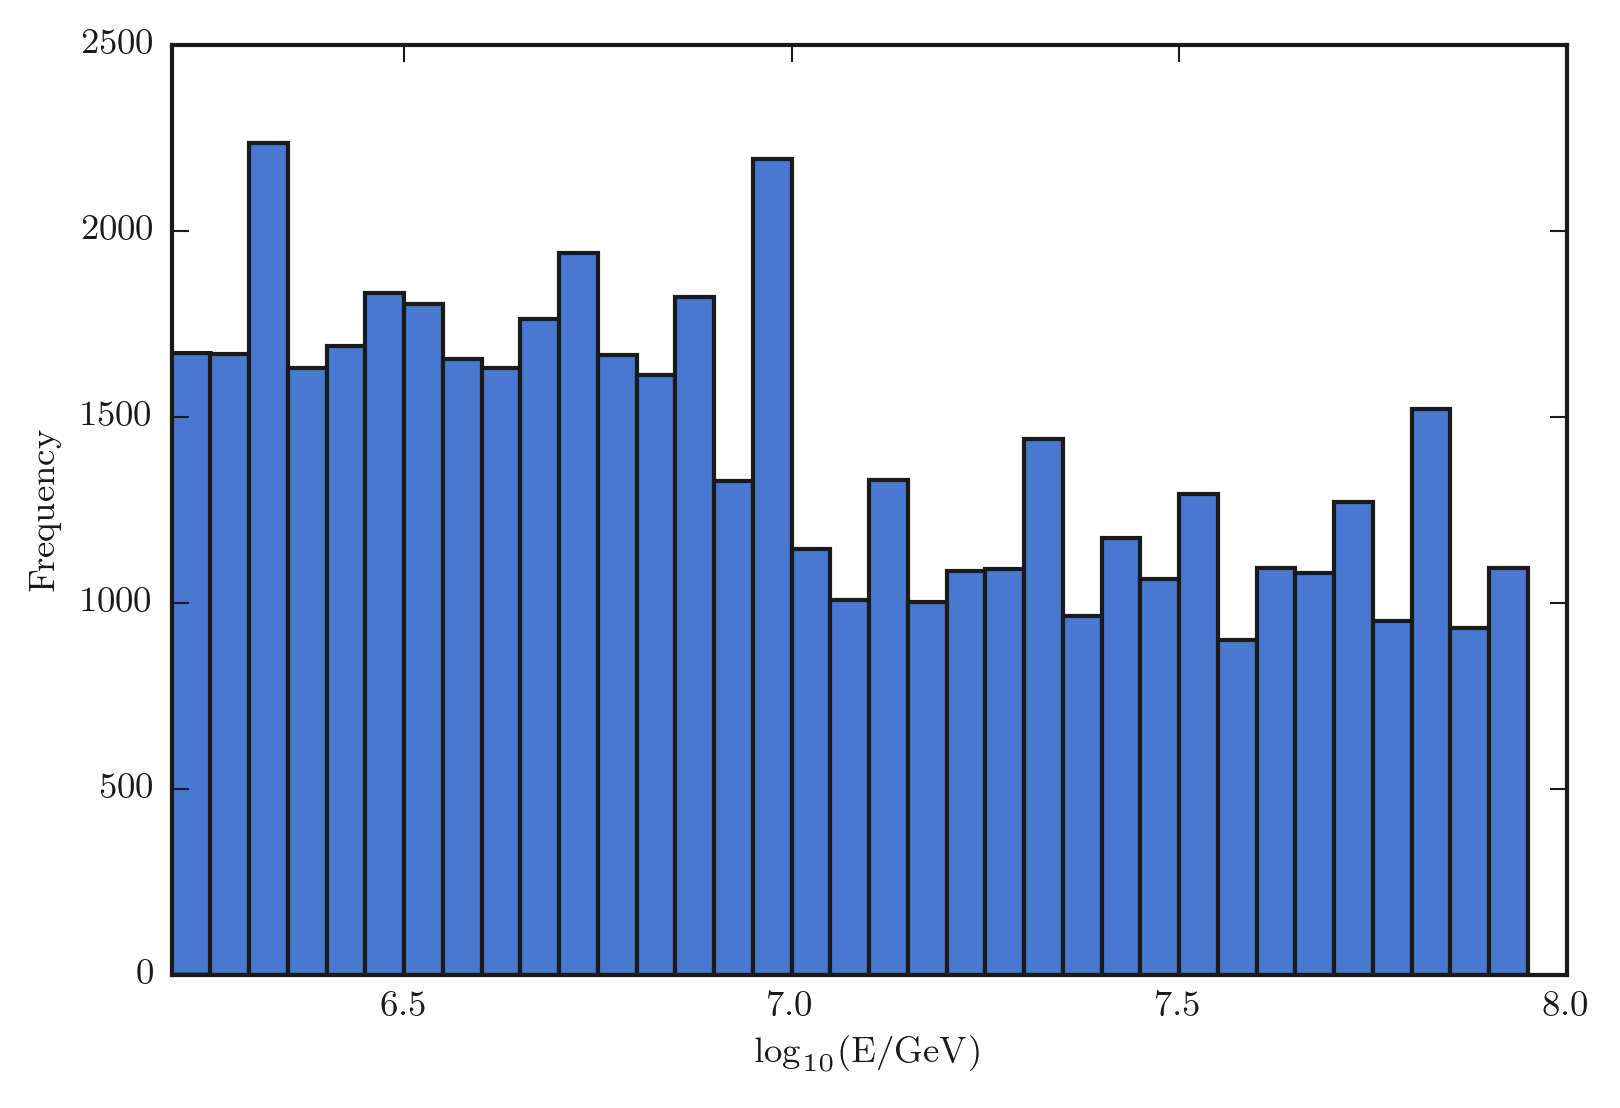

In [17]:
df.reco_log_energy.plot(kind='hist', xlim=[6.2, 8], bins=np.arange(6.2, 8, 0.05))
plt.xlabel('$\\log_{10}({\mathrm{E/GeV})$')

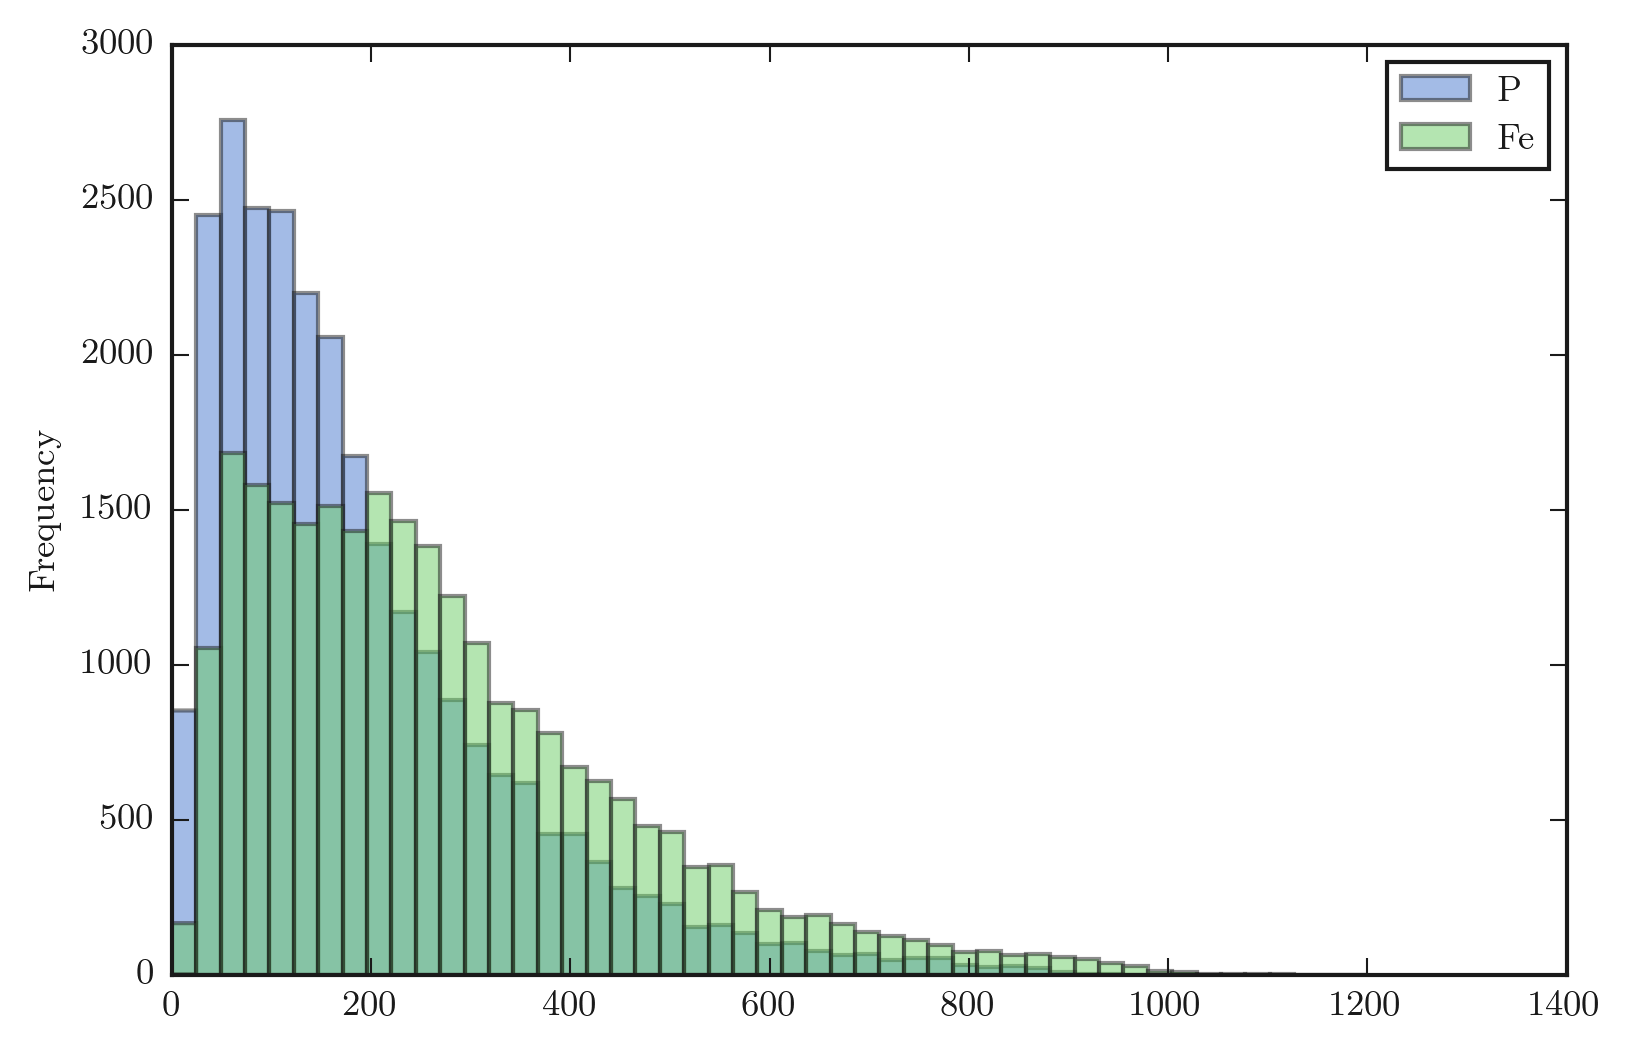

In [18]:
fig, ax = plt.subplots()
df.NChannels[df.MC_comp == 'P'].plot(kind='hist', bins=np.linspace(0, 1200, 50), alpha=0.5, label='P')
df.NChannels[df.MC_comp == 'Fe'].plot(kind='hist', bins=np.linspace(0, 1200, 50), alpha=0.5, label='Fe')
plt.legend()

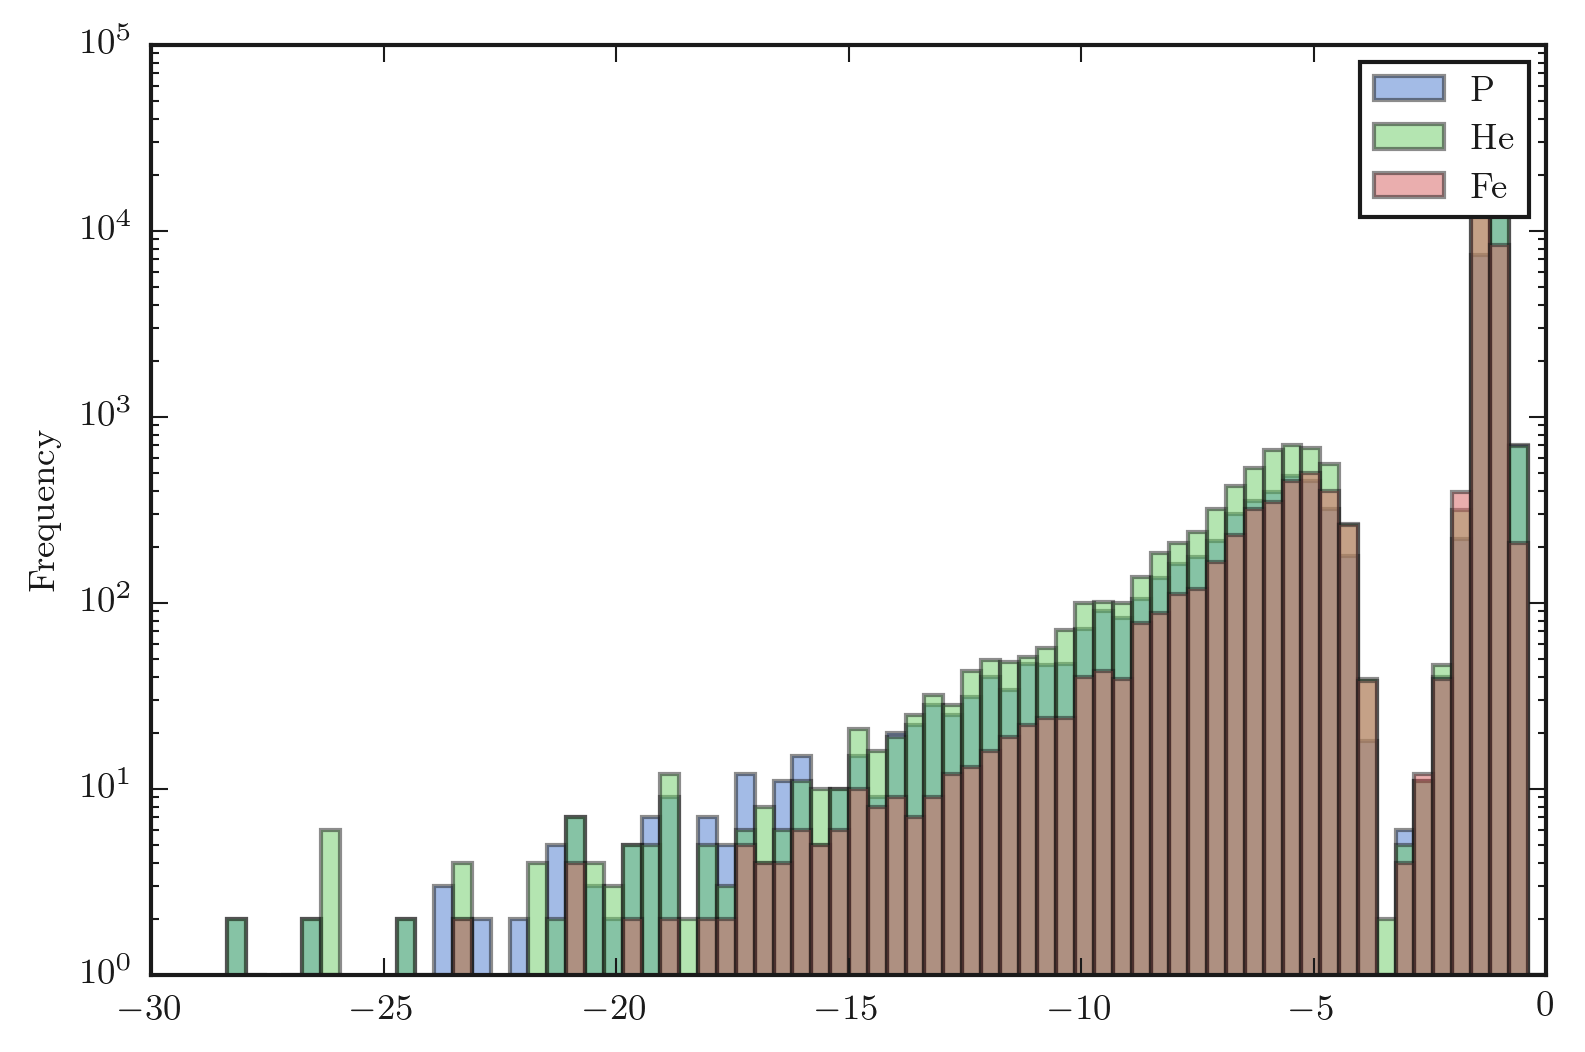

In [13]:
fig, ax = plt.subplots()
df.lap_likelihood[df.MC_comp == 'P'].plot(kind='hist', bins=np.linspace(-30, 0, 75), alpha=0.5, label='P', log=True)
df.lap_likelihood[df.MC_comp == 'He'].plot(kind='hist', bins=np.linspace(-30, 0, 75), alpha=0.5, label='He')
df.lap_likelihood[df.MC_comp == 'Fe'].plot(kind='hist', bins=np.linspace(-30, 0, 75), alpha=0.5, label='Fe')
plt.legend()

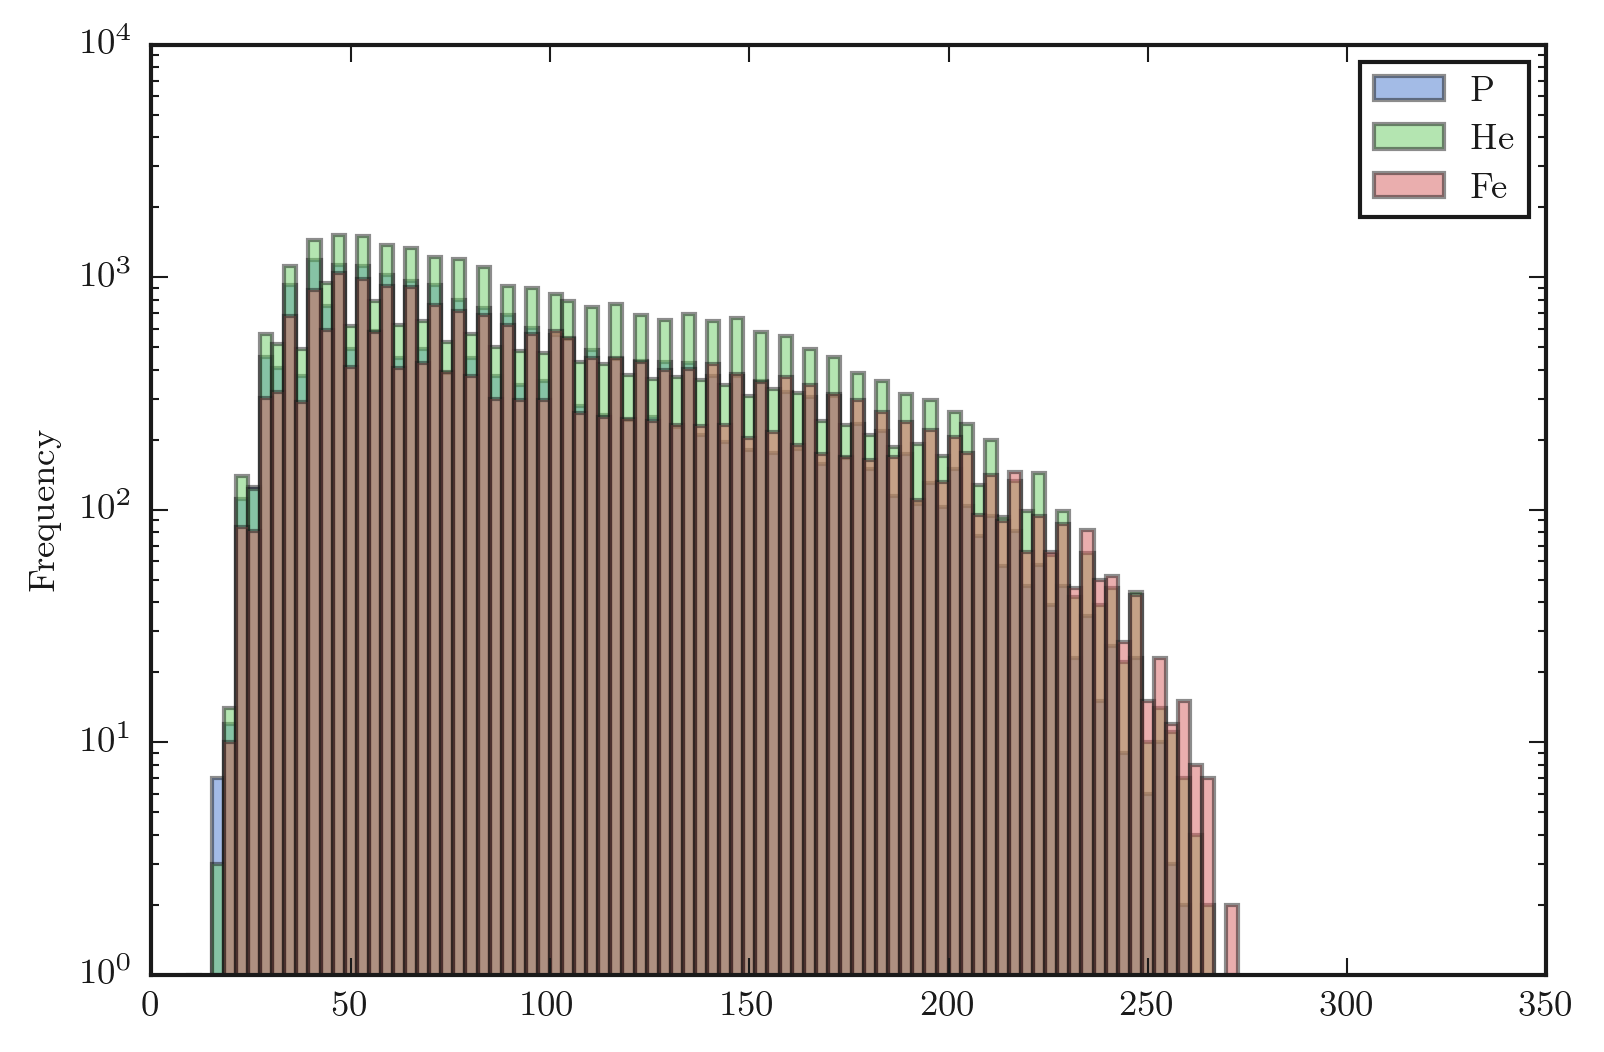

In [10]:
fig, ax = plt.subplots()
df.lap_ndf[df.MC_comp == 'P'].plot(kind='hist', bins=np.linspace(0, 300, 100), alpha=0.5, label='P', log=True)
df.lap_ndf[df.MC_comp == 'He'].plot(kind='hist', bins=np.linspace(0, 300, 100), alpha=0.5, label='He')
df.lap_ndf[df.MC_comp == 'Fe'].plot(kind='hist', bins=np.linspace(0, 300, 100), alpha=0.5, label='Fe')
plt.legend()